# Japan Public Finance Energy Investment Analysis 2015-2017

Begin by importing necessary python packages

In [1]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from matplotlib import ticker

Upload data : spreadsheet and country latitudes and longitudes

In [2]:
# names of data files
data_filename = 'Public Finance Database - Analyst task (1).xlsx'
countries_filename = 'countries.csv'

# read files
data = pd.read_excel(data_filename, sheet_name=1)
countries = pd.read_csv(countries_filename)

Just a quick peek to show we've correctly uploaded the finance data

In [3]:
data.head()

,amountUSD,FY,mechanism,institution,institutionKind,project,projectDesc,country,region,category,sector,stage,entity
0,16826400,2015,Grant,Japan International Cooperation Agency,Bilateral,Project for Reinforcement of Transmission Netw...,This project will construct a new substation i...,Mozambique,Sub-Saharan Africa,Other,Mixed or unclear - Other,Transmission & Distribution,Republic of Mozambique
1,182790647,2015,Loan,Japan International Cooperation Agency,Bilateral,Odisha Transmission System Improvement Project,The Government of Odisha State plans to increa...,India,South Asia,Other,Mixed or unclear - Other,Transmission & Distribution,India
2,237942148,2015,Loan,Japan International Cooperation Agency,Bilateral,Nacala Port Development Project Phase II,The project aims to increase cargo-handling pr...,Mozambique,Sub-Saharan Africa,Fossil Fuel,Coal,Transportation,Republic of Mozambique
3,20675140,2015,Grant,Japan International Cooperation Agency,Bilateral,Project for Energy Saving in Water Supply Syst...,The pumping capacity of many of the tube wells...,Pakistan,South Asia,Clean,Efficiency - Clean,Point of Use,Islamic Republic of Pakistan
4,438545982,2015,Loan,Japan International Cooperation Agency,Bilateral,Electricity Sector Reconstruction Project (Pha...,Due to repeated wars and economic sanctions si...,Iraq,Middle East & North Africa,Other,Mixed or unclear - Other,Transmission & Distribution,Republic of Iraq


## Financing By Year and Category
First, we manipulate the data to find out the amount of public finance going to different categories and sectors of energy projects, and how that has changed in the three years

In [4]:
amount_by_sector = data.groupby(['category','sector', 'FY']).sum()['amountUSD'].unstack().T.fillna(0)
amount_by_sector.head()

category       Clean                                                     \
sector       Climate Efficiency - Clean   Geothermal Renewables - Clean   
FY                                                                        
2015      94300000.0         20675140.0  499921997.0                0.0   
2016             0.0        146208000.0  883056000.0         25000000.0   
2017             0.0         15000000.0  690406500.0                0.0   

category                                                              \
sector   Renewables and Efficiency - Other        Solar         Wind   
FY                                                                     
2015                           100000000.0  112202678.0  698497733.0   
2016                           100000000.0   17678150.0   65000000.0   
2017                                   0.0  103511910.0  338805200.0   

category                  Fossil Fuel                                    \
sector   Wind and Solar          Coal Efficiency - Fossil   Natural Gas   
FY                                                                        
2015        277140000.0  1.425413e+09                 0.0  2.813347e+09   
2016                0.0  6.351846e+09          10606330.0  3.319591e+09   
2017                0.0  3.714400e+09                 0.0  1.241200e+08   

category                                  Other                           \
sector             Oil   Oil and Gas    Biomass    Climate Hydro - Large   
FY                                                                         
2015      8.000000e+08  2.913000e+09        0.0        0.0           0.0   
2016      1.634717e+09  1.350000e+08  6100000.0  8458760.0           0.0   
2017      3.269000e+09  9.642470e+08        0.0        0.0    98025100.0   

category                                              \
sector   Mixed or unclear - Other Renewables - Other   
FY                                                     
2015                 2.191928e+09        100000000.0   
2016                 1.177903e+09                0.0   
2017                 5.043992e+08                0.0   

category                                    
sector   Renewables and Efficiency - Other  
FY                                          
2015                           750000000.0  
2016                                   0.0  
2017                                   0.0

Here, we manipulate the data to combine some sectors: sorted renewables into wind and solar, geothermal, and others, dividing the "Other" category into Large Hydro, Other Renewables and Mixed/Unclear, and neglecting the 'Fossil Efficiency' sector since it is relatively insignificant

In [5]:
amount_by_sector['Clean', 'Other'] = (amount_by_sector['Clean'].sum(axis=1) -
                                      amount_by_sector['Clean','Wind'] - 
                                      amount_by_sector['Clean','Solar'] - 
                                      amount_by_sector['Clean','Solar'] -
                                      amount_by_sector['Clean','Geothermal'])

amount_by_sector['Clean', 'Solar +Wind'] = (amount_by_sector['Clean','Wind'] +
                                               amount_by_sector['Clean','Solar'] +
                                               amount_by_sector['Clean','Wind and Solar'])

amount_by_sector['Other', 'Mixed/Unclear'] = (amount_by_sector['Other'].sum(axis=1) - 
                                              amount_by_sector['Other','Hydro - Large'] -
                                              amount_by_sector['Other','Renewables - Other'] -
                                              amount_by_sector['Other','Renewables and Efficiency - Other'])

amount_by_sector['Other', 'Other Renewables'] = (amount_by_sector['Other','Renewables - Other'] +
                                                 amount_by_sector['Other','Renewables and Efficiency - Other'])

## Plot

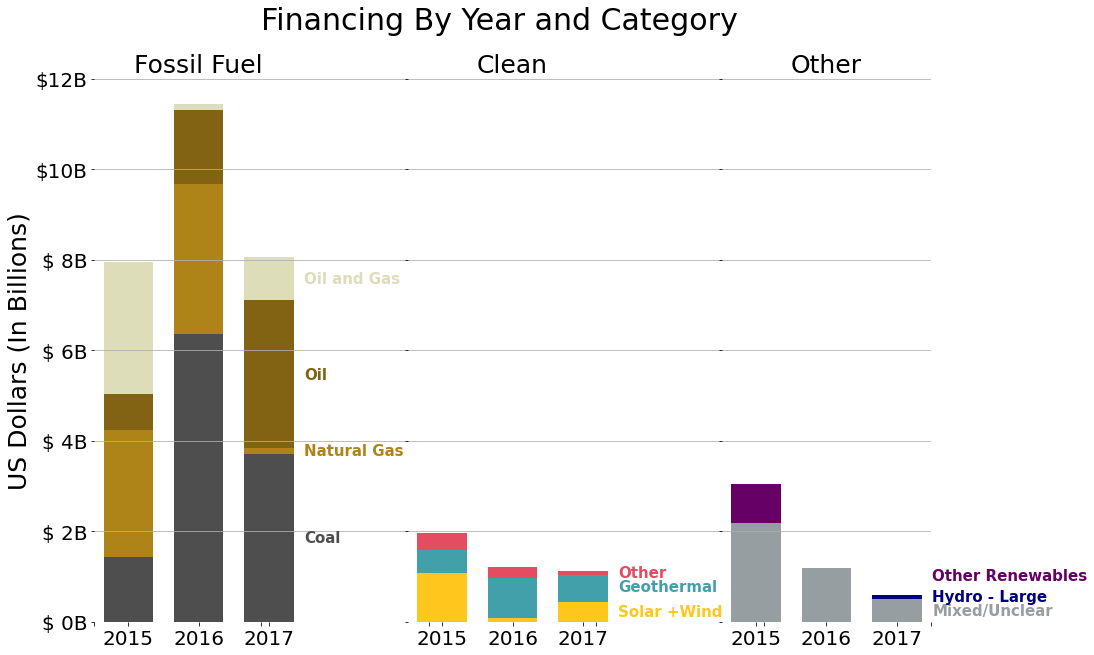

In [7]:
fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,10))

# size customizations
width = 0.7
title = 30
subtitle = 25
ylabel = 25
yticks = 20
xticks = 20
legend = 15

#specifying plot orders and colors
labels = amount_by_sector.index.values
categories = ['Fossil Fuel', 'Clean', 'Other']
sectors = {'Fossil Fuel': ['Coal', 'Natural Gas', 'Oil', 'Oil and Gas'],
           'Clean': ['Solar +Wind', 'Geothermal', 'Other'],
           'Other': ['Mixed/Unclear', 'Hydro - Large', 'Other Renewables']}

colors = {'Fossil Fuel': ['#4f4e4e', '#ae8419', '#826313', '#ddddb9'],
          'Clean': ['#ffc71e', '#41a0aa', '#e44c62'],
          'Other': ['#969ea1', '#000080', '#660066']}

total = np.zeros(3)

for i, category in enumerate(categories):
  
  ax = axes[i]
  total = np.zeros(3)
  legend_sum = 0

  for j, sector in enumerate(sectors[category]):
  
    values = amount_by_sector[category][sector].values
    ax.bar(labels, values, width, bottom=total, label=sector, color=colors[category][j])
    ax.yaxis.set_major_formatter(lambda x, pos: '${:2.0f}B'.format(x*1e-9))
    ax.tick_params(axis='y', labelsize=yticks)
    ax.tick_params(axis='x', labelsize=xticks)
    for _, spine in ax.spines.items():
      spine.set_visible(False)
    if (i==2 and j ==2):
      add_to_legend = amount_by_sector[category][sector][2015] / 2
    else:
      add_to_legend = amount_by_sector[category][sector][2017] / 2
    legend_sum += add_to_legend
    ax.text(2017.5, legend_sum - 1e8, sector, transform=ax.transData, color=colors[category][j], fontsize=legend, weight='bold')
    legend_sum += add_to_legend
    ax.set_title(category, fontsize=subtitle)
    ax.grid(which='major', visible=True, axis='y')
    if i==0:
      ax.set_ylabel('US Dollars (In Billions)', fontsize=ylabel)
    
    total += values
  

fig.suptitle('Financing By Year and Category', fontsize=title)
fig.subplots_adjust(wspace=0.5)

ax3 = fig.add_subplot(111, zorder=-1)
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax3.get_shared_y_axes().join(ax3,axes[0])
ax3.grid(axis="y")

#plt.savefig('year-and-category.jpg', bbox_inches='tight')
plt.show()

## Financing By Bank and Category
Campaigners might want to know the mix of projects that each bank is funding. Here we manipulate the data to find out the amount of public finance going to different categories for each bank, and how that has changed in the three years

In [8]:
amount_by_bank = data.groupby(['institution', 'category', 'FY']).sum()['amountUSD'].unstack().T.fillna(0)
amount_by_bank.head()

institution Japan Bank for International Co-operation                \
category                                        Clean   Fossil Fuel   
FY                                                                    
2015                                      687637733.0  5.609882e+09   
2016                                      366791100.0  7.318585e+09   
2017                                      380800000.0  4.936565e+09   

institution              Japan International Cooperation Agency                \
category           Other                                  Clean   Fossil Fuel   
FY                                                                              
2015         100000000.0                           1.061560e+09  1.290701e+09   
2016         293172800.0                           7.381510e+08  9.108423e+08   
2017                 0.0                           4.143836e+08  3.442464e+08   

institution               Nippon Export and Investment Insurance  \
category            Other                                  Clean   
FY                                                                 
2015         2.941928e+09                             53540000.0   
2016         4.631730e+08                            132000000.0   
2017         6.024243e+08                            352540000.0   

institution                             
category      Fossil Fuel        Other  
FY                                      
2015         1.051177e+09          0.0  
2016         3.222333e+09  436115600.0  
2017         2.790956e+09          0.0

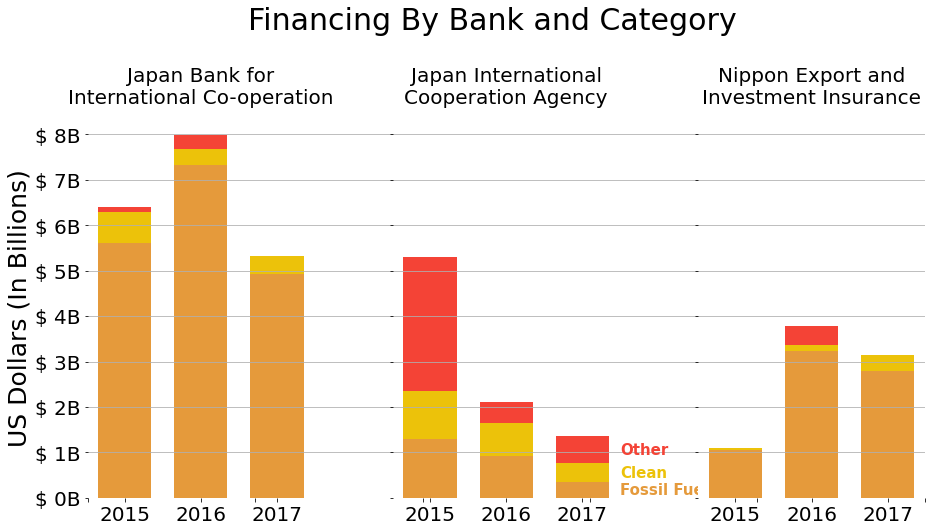

In [9]:
fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,7))

# size customizations
width = 0.7
title = 30
subtitle = 20
ylabel = 25
yticks = 20
xticks = 20
legend = 15
wspace = 0.35

#specifying plot orders and colors
labels = amount_by_sector.index.values
banks = ['Japan Bank for International Co-operation',
         'Japan International Cooperation Agency',
         'Nippon Export and Investment Insurance']
bank_titles = ['Japan Bank for\nInternational Co-operation',
         'Japan International\nCooperation Agency',
         'Nippon Export and\nInvestment Insurance']
categories = ['Fossil Fuel', 'Clean', 'Other']

colors = ['#e59a3b', '#ecc20a', '#f44336']

total = np.zeros(3)

for i, bank in enumerate(banks):
  
  ax = axes[i]
  total = np.zeros(3)
  legend_sum = 0

  for j, category in enumerate(categories):
  
    values = amount_by_bank[bank][category].values
    ax.bar(labels, values, width, bottom=total, label=sector, color=colors[j])
    ax.yaxis.set_major_formatter(lambda x, pos: '${:2.0f}B'.format(x*1e-9))
    ax.tick_params(axis='y', labelsize=yticks)
    ax.tick_params(axis='x', labelsize=xticks)
    for _, spine in ax.spines.items():
      spine.set_visible(False)

    if i == 1:
      legend_sum += amount_by_bank[bank][category][2017] / 2
      ax.text(2017.5, legend_sum - 1e8, category, transform=ax.transData,
              fontsize=legend, weight='bold', color=colors[j])
      legend_sum += amount_by_bank[bank][category][2017] / 2

    ax.set_title(bank_titles[i], fontsize=subtitle, y=1.02)
    ax.grid(which='major', visible=True, axis='y')

    if i==0:
      ax.set_ylabel('US Dollars (In Billions)', fontsize=ylabel)
    
    total += values
  

fig.suptitle('Financing By Bank and Category', fontsize=title, y=1.1)
fig.subplots_adjust(wspace=wspace)

ax3 = fig.add_subplot(111, zorder=-1)
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax3.get_shared_y_axes().join(ax3,axes[0])
ax3.grid(axis="y")

#plt.savefig('bank-and-category.jpg', bbox_inches='tight')
plt.show()

## Mapping Finance Flows
We might want to visualize where the money is flowing. Here we manipulate the data to find out the amount of public finance going to different countries, per finance category. We needed to change some country names from the dataset to match the lat/long dataset as well.

In [10]:
clean_by_country = data.groupby(['category', 'country']).sum().loc['Clean'].reset_index()
fossil_by_country = data.groupby(['category', 'country']).sum().loc['Fossil Fuel'].reset_index()
other_by_country = data.groupby(['category', 'country']).sum().loc['Other'].reset_index()

#edit some country names
fossil_by_country.loc[11,'country'] = 'Russia'
fossil_by_country.loc[18,'country'] = 'Vietnam'
fossil_by_country.loc[14,'country'] = 'Congo [DRC]'
fossil_by_country.loc[7,'country'] = 'Marshall Islands'

clean_by_country.loc[5,'country'] = 'Papua New Guinea'
clean_by_country.loc[14,'country'] = 'Paraguay'
clean_by_country.loc[15,'country'] = 'Marshall Islands'

other_by_country.loc[20,'country'] = 'Vietnam'
other_by_country.loc[4,'country'] = 'Colombia'
other_by_country.loc[9,'country'] = 'Burma'

Here we merge the country finance datasets with the lat/long dataset in order to map locations

In [11]:
fossil_by_country = pd.merge(countries, fossil_by_country)
clean_by_country = pd.merge(countries, clean_by_country)
other_by_country = pd.merge(countries, other_by_country)

## Plot

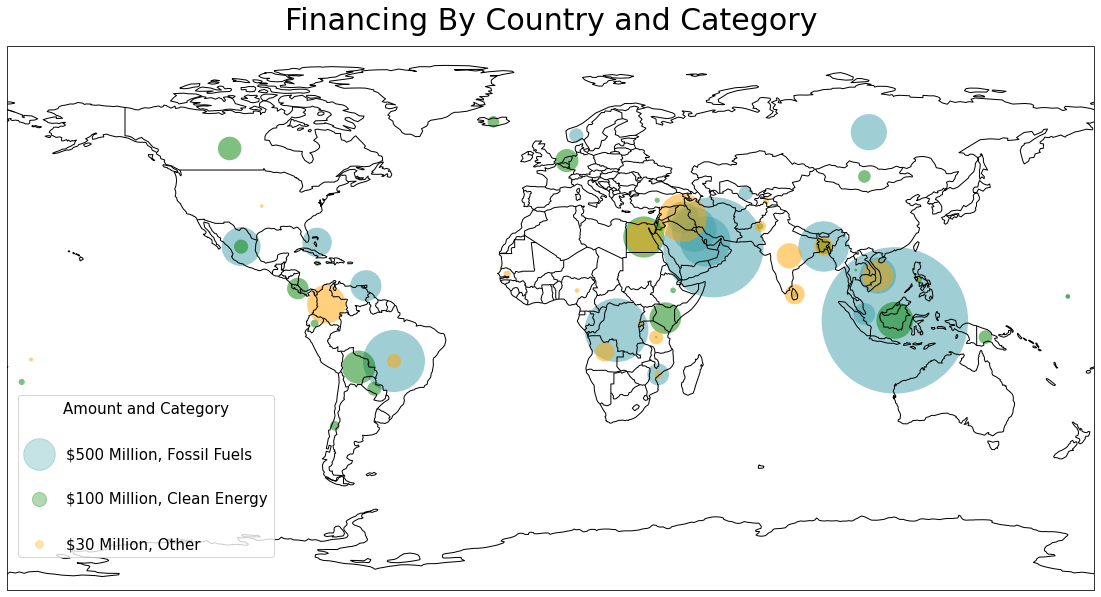

In [12]:
countries_by_category = [fossil_by_country, clean_by_country, other_by_country]
colors = ['#41a0aa', '#008000', '#ffa500']
legends = ['Fossil Fuels', 'Clean Energy', 'Other']
scale = 5e5

ax = plt.axes(projection=ccrs.PlateCarree())

for i, category in enumerate(countries_by_category):
  lat = category['lat']
  lon = category['long']
  amount = category['amountUSD']

  ax.scatter(lon, lat, label=None, color=colors[i],
             s=amount/scale, linewidth=0, alpha=0.5)

ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

fig = plt.gcf().set_size_inches(20, 10)

ax.set_xlim(left=-180, right=180)
ax.set_ylim(top=90, bottom=-90)
ax.set_title('Financing By Country and Category', fontsize=title, y=1.02)

# Here we create a legend:
# we'll plot empty lists with the desired size and label
for i, area in enumerate([5e8, 1e8, 3e7]):
    ax.scatter([], [], c=colors[i], alpha=0.3, s=area/scale,
                label='$' + str(int(area/1e6)) + ' Million, ' + legends[i])
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, title='Amount and Category',
          fontsize=15, loc=(0.01,0.06), title_fontsize=15)

#plt.savefig('map-and-category.jpg', bbox_inches='tight')

## Financing Mechanisms
Finally, what are the mechanisms behind the financing Here, we do a simple split of the data by finance category.

Some data mainpulation to get the total amount per financing mechanism

In [13]:
data_by_mechanism = data.groupby('mechanism').sum()
data_by_mechanism = data_by_mechanism.reindex(index = ['Equity', 'Loan', 'Grant', 'Guarantee'])
data_by_mechanism.head()

,amountUSD,FY
mechanism,,
Equity,847187050,6046
Loan,26524881450,187471
Grant,213526631,30241
Guarantee,8913908891,72579


## Plot
A pie chart with helpful labels for dollar amounts and percentages

Text(0.5, 0.98, 'Financing Mechanisms')

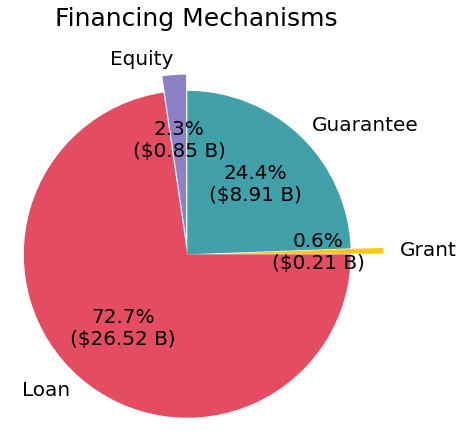

In [14]:
# settings
title = 25
labelsize = 20
colors = ['#8c81c5', '#e44c62', '#ffc71e', '#41a0aa']

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = data_by_mechanism['amountUSD'].index.values
sizes = data_by_mechanism['amountUSD']
explode = (0.1, 0, 0.2, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(7,7))

def func(pct, allvals):
    absolute = (pct/(100.*1e9)*np.sum(allvals))
    return "{:.1f}%\n(${:.2f} B)".format(pct, absolute)
  
ax.pie(sizes, labels=labels, explode=explode, autopct=lambda pct: func(pct, sizes), colors=colors,
        shadow=False, startangle=90, textprops={'fontsize': labelsize})

#ax.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors,
#        shadow=False, startangle=90, textprops={'fontsize': labelsize})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.suptitle('Financing Mechanisms', fontsize=title)

#plt.savefig('pie.jpg', bbox_inches='tight')